In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
import tensorflow as tf

from scipy import interpolate
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [2]:
N = 100000
N2 = int(N/2)

sr_s1, sr_s2, sb_s1, sb_s2 = 0.1, -0.1, 0.05, 0
SR_background_data = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N)
SB_background_data = np.random.multivariate_normal([1,0],[[1,0],[0,1]],N)
SR_background_sim = np.random.multivariate_normal([sr_s1,sr_s2],[[1,0],[0,1]],N)
SB_background_sim = np.random.multivariate_normal([1 + sb_s1,sb_s2],[[1,0],[0,1]],N)

SR_signal = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N)

SR_background_data_fortest = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N*10)
SR_signal_fortest = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N*10)

EPOCHS = 50

Text(0, 0.5, 'events')

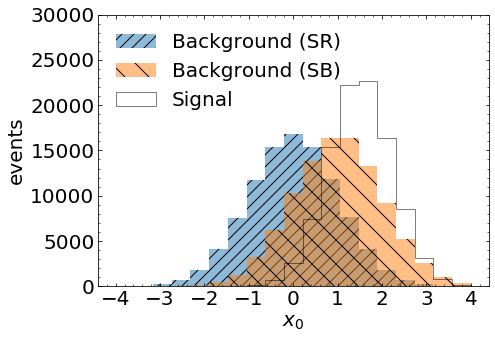

In [3]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SB_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SR_signal[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_0$",fontsize=20)
plt.ylabel("events",fontsize=20)

Text(0, 0.5, 'events')

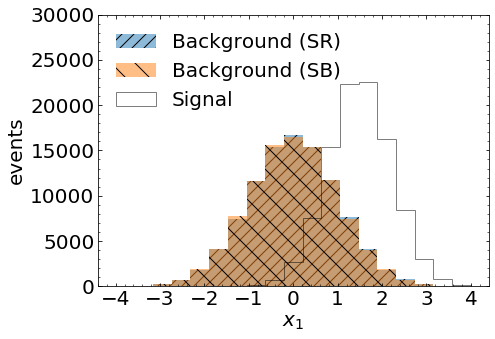

In [4]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SB_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SR_signal[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_1$",fontsize=20)
plt.ylabel("events",fontsize=20)

In [5]:
#First, let's do fully supervised

X_sup_train = np.concatenate([SR_signal,SR_background_data])
Y_sup_train = np.concatenate([np.ones(len(SR_signal)),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_sup_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [6]:
model_sup = Sequential()
model_sup.add(Dense(64, input_dim=2, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup = model_sup.predict(X_sup_val,batch_size=int(0.1*len(X_sup_val)))
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/50
200000/200000 [==============================] - 1s 3us/step - loss: 0.6278 - acc: 0.7445
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4932 - acc: 0.8165
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3861 - acc: 0.8543
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3110 - acc: 0.8807
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2743 - acc: 0.8891
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2609 - acc: 0.8931
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2541 - acc: 0.8957
Epoch 8/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2503 - acc: 0.8975
Epoch 9/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2488 - acc: 0.8980
Epoch 10/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2483 - a

In [7]:
model_sup1d = Sequential()
model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(1, activation='sigmoid'))
model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup1d.fit(X_sup_train[:,1], Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup1d = model_sup1d.predict(X_sup_val[:,1],batch_size=int(0.1*len(X_sup_val)))
fpr_sup1d, tpr_sup1d, _ = roc_curve(Y_sup_val, scores_sup1d)

Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 0.6764 - acc: 0.5712
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6025 - acc: 0.7415
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5408 - acc: 0.7523
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4897 - acc: 0.7737
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4485 - acc: 0.8027
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4225 - acc: 0.8131
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4119 - acc: 0.8145
Epoch 8/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4097 - acc: 0.8146
Epoch 9/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4096 - acc: 0.8145
Epoch 10/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4097 - a

In [8]:
Nsig = 500
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2])**0.5)
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2]))

2.23606797749979
0.01


In [9]:
n_injections = 5
signals_to_inject = [None] * n_injections
for i in range(n_injections):
    signals_to_inject[i] = SR_signal[np.random.choice(SR_signal.shape[0], size=Nsig, replace=False), :]

In [10]:
#Now let's do data versus sim
dvsim_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(5):
    print('Training i = %i' % i)
    signal_to_inject = signals_to_inject[i]
    
    X_dvsim_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SR_background_sim[0:N2]])
    Y_dvsim_train = np.concatenate([np.ones(len(signal_to_inject)),np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SR_background_sim[0:N2]))])

    X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

    X_dvsim_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_dvsim_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    model_dvsim = Sequential()
    model_dvsim.add(Dense(64, input_dim=2, activation='relu')) 
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(1, activation='sigmoid'))
    model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_dvsim = model_dvsim.fit(X_dvsim_train, Y_dvsim_train, epochs=EPOCHS, 
                                 batch_size=int(0.1*len(X_dvsim_train)))

    scores_dvsim = model_dvsim.predict(X_dvsim_val,batch_size=int(0.1*len(X_dvsim_val)))
    fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)
    dvsim_rocs = dvsim_rocs.append({'fpr': fpr_dvsim, 'tpr': tpr_dvsim}, ignore_index=True)

Training i = 0
Epoch 1/50
100500/100500 [==============================] - 0s 4us/step - loss: 0.6916 - acc: 0.5208
Epoch 2/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6910 - acc: 0.5274
Epoch 3/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6908 - acc: 0.5274
Epoch 4/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5274
Epoch 5/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5276
Epoch 6/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5271
Epoch 7/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5283
Epoch 8/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5280
Epoch 9/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5277
Epoch 10/50
100500/100500 [==============================] - 0s 1us/step - l

100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5272
Epoch 32/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5280
Epoch 33/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5286
Epoch 34/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5278
Epoch 35/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5281
Epoch 36/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5284
Epoch 37/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5279
Epoch 38/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5279
Epoch 39/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5290
Epoch 40/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc:

100500/100500 [==============================] - 0s 1us/step - loss: 0.6908 - acc: 0.5271
Epoch 12/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5277
Epoch 13/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5276
Epoch 14/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5270
Epoch 15/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5279
Epoch 16/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5282
Epoch 17/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5280
Epoch 18/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5276
Epoch 19/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc: 0.5280
Epoch 20/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6907 - acc:

100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5277
Epoch 42/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5289
Epoch 43/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5277
Epoch 44/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5285
Epoch 45/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5283
Epoch 46/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5279
Epoch 47/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5283
Epoch 48/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6905 - acc: 0.5291
Epoch 49/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6906 - acc: 0.5290
Epoch 50/50
100500/100500 [==============================] - 0s 1us/step - loss: 0.6905 - acc:

In [11]:
#Now let's do optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(5):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]
    
    X_ocwola_train = np.concatenate([signal_to_inject,SR_background_data[0:N2],SR_background_data[N2:-1]])
    Y_ocwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                     np.zeros(len(SR_background_data[N2:-1]))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    X_ocwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    model_ocwola = Sequential()
    model_ocwola.add(Dense(64, input_dim=2, activation='relu')) 
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(1, activation='sigmoid'))
    model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_ocwola = model_ocwola.fit(X_ocwola_train, Y_ocwola_train, epochs=EPOCHS, 
                                   batch_size=int(0.1*len(X_ocwola_train)))

    scores_ocwola = model_ocwola.predict(X_ocwola_val,batch_size=int(0.1*len(X_ocwola_val)))
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

Training i = 0
Epoch 1/50
100499/100499 [==============================] - 1s 5us/step - loss: 0.6932 - acc: 0.5026
Epoch 2/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5035
Epoch 3/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5032
Epoch 4/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5014
Epoch 5/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5027
Epoch 6/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5039
Epoch 7/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5034
Epoch 8/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.4992
Epoch 9/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6935 - acc: 0.5030
Epoch 10/50
100499/100499 [==============================] - 0s 1us/step - l

100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5031
Epoch 32/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5023
Epoch 33/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5029
Epoch 34/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6935 - acc: 0.5040
Epoch 35/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6935 - acc: 0.5038
Epoch 36/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6936 - acc: 0.5025
Epoch 37/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5031
Epoch 38/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5018
Epoch 39/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5018
Epoch 40/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc:

100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5012
Epoch 12/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6940 - acc: 0.4992
Epoch 13/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6941 - acc: 0.4991
Epoch 14/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5007
Epoch 15/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6935 - acc: 0.5032
Epoch 16/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6935 - acc: 0.5049
Epoch 17/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5052
Epoch 18/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5051
Epoch 19/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5055
Epoch 20/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc:

100499/100499 [==============================] - 0s 1us/step - loss: 0.6941 - acc: 0.5007
Epoch 42/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6937 - acc: 0.5016
Epoch 43/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5026
Epoch 44/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5015
Epoch 45/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5023
Epoch 46/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5036
Epoch 47/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6939 - acc: 0.5031
Epoch 48/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6938 - acc: 0.5027
Epoch 49/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6935 - acc: 0.5033
Epoch 50/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc:

Text(0, 0.5, 'Events')

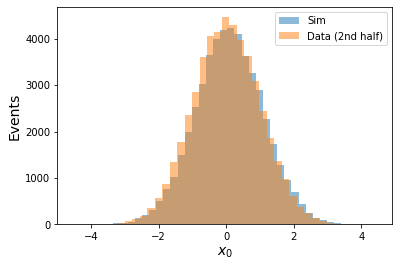

In [12]:
_, b, _ = plt.hist(SR_background_sim[0:N2, 0], bins=40, alpha=0.5, label='Sim')
plt.hist(SR_background_data[N2:-1, 0], bins=40, alpha=0.5, label='Data (2nd half)')
plt.legend()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('Events', fontsize=14)

Text(0, 0.5, 'Events')

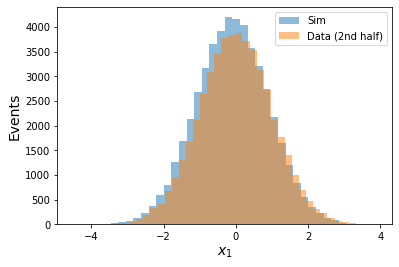

In [13]:
_, b, _ = plt.hist(SR_background_sim[0:N2, 1], bins=40, alpha=0.5, label='Sim')
plt.hist(SR_background_data[N2:-1, 1], bins=40, alpha=0.5, label='Data (2nd half)')
plt.legend()
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('Events', fontsize=14)

In [14]:
#Next is CWoLa
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(5):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]
    
    X_cwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2], SB_background_data[N2:-1]])
    Y_cwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SB_background_data[N2:-1]))])

    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train)

    X_cwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=2, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(X_cwola_train, Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=int(0.1*len(X_cwola_train)))

    scores_cwola = model_cwola.predict(X_cwola_val,batch_size=int(0.1*len(X_cwola_val)))
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

Training i = 0
Epoch 1/50
100499/100499 [==============================] - 1s 8us/step - loss: 0.6636 - acc: 0.6491
Epoch 2/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.6216 - acc: 0.6739
Epoch 3/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5975 - acc: 0.6834
Epoch 4/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5909 - acc: 0.6846
Epoch 5/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5918 - acc: 0.6859
Epoch 6/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5873 - acc: 0.6869
Epoch 7/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5880 - acc: 0.6857
Epoch 8/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5874 - acc: 0.6865
Epoch 9/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5865 - acc: 0.6879
Epoch 10/50
100499/100499 [==============================] - 0s 1us/step - l

100499/100499 [==============================] - 0s 1us/step - loss: 0.5872 - acc: 0.6878
Epoch 32/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6877
Epoch 33/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5870 - acc: 0.6867
Epoch 34/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5865 - acc: 0.6882
Epoch 35/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5870 - acc: 0.6883
Epoch 36/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5877 - acc: 0.6861
Epoch 37/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5867 - acc: 0.6882
Epoch 38/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6877
Epoch 39/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5871 - acc: 0.6882
Epoch 40/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5880 - acc:

100499/100499 [==============================] - 0s 1us/step - loss: 0.5883 - acc: 0.6849
Epoch 12/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5885 - acc: 0.6850
Epoch 13/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5912 - acc: 0.6861
Epoch 14/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5873 - acc: 0.6867
Epoch 15/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5905 - acc: 0.6837
Epoch 16/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5878 - acc: 0.6862
Epoch 17/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5899 - acc: 0.6866
Epoch 18/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5879 - acc: 0.6870
Epoch 19/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5874 - acc: 0.6872
Epoch 20/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5877 - acc:

100499/100499 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6882
Epoch 42/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5866 - acc: 0.6879
Epoch 43/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5871 - acc: 0.6872
Epoch 44/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5880 - acc: 0.6857
Epoch 45/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6863
Epoch 46/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5872 - acc: 0.6869
Epoch 47/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5874 - acc: 0.6869
Epoch 48/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6878
Epoch 49/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5863 - acc: 0.6886
Epoch 50/50
100499/100499 [==============================] - 0s 1us/step - loss: 0.5870 - acc:

In [15]:
#Next is SA-CWoLa

mylambda = 1.

sacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(5):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]

    X_sacwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SB_background_data[N2:-1],
                                      SR_background_sim[0:N2],SB_background_sim[N2:-1]])
    Y_sacwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                      np.zeros(len(SB_background_data[N2:-1])),
                                      np.ones(len(SR_background_sim[0:N2])),
                                      np.zeros(len(SB_background_sim[N2:-1]))])
    W_sacwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                      np.ones(len(SB_background_data[N2:-1])),
                                      -mylambda*np.ones(len(SR_background_sim[0:N2])),
                                      -mylambda*np.ones(len(SB_background_sim[N2:-1]))])

    X_sacwola_train, Y_sacwola_train, W_sacwola_train = shuffle(X_sacwola_train, Y_sacwola_train,W_sacwola_train)

    X_sacwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_sacwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    model_sacwola = Sequential()
    model_sacwola.add(Dense(64, input_dim=2, activation='relu')) 
    model_sacwola.add(Dense(64, activation='relu'))
    model_sacwola.add(Dense(64, activation='relu'))
    model_sacwola.add(Dense(1, activation='sigmoid'))
    model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_sacwola = model_sacwola.fit(X_sacwola_train, Y_sacwola_train, epochs=EPOCHS, 
                                     batch_size=int(0.1*len(X_sacwola_train)),sample_weight=W_sacwola_train)

    scores_sacwola = model_sacwola.predict(X_sacwola_val,batch_size=int(0.1*len(X_sacwola_val)))
    fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_sacwola_val, scores_sacwola)
    
    sacwola_rocs = sacwola_rocs.append({'fpr': fpr_sacwola, 'tpr': tpr_sacwola}, ignore_index=True)

Training i = 0
Epoch 1/50
200498/200498 [==============================] - 1s 5us/step - loss: 0.0017 - acc: 0.4852
Epoch 2/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0026 - acc: 0.5123
Epoch 3/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0057 - acc: 0.5480
Epoch 4/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0093 - acc: 0.5609
Epoch 5/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0110 - acc: 0.5522
Epoch 6/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0103 - acc: 0.5439
Epoch 7/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0112 - acc: 0.5540
Epoch 8/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0124 - acc: 0.5554
Epoch 9/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0157 - acc: 0.5489
Epoch 10/50
200498/200498 [==============================] - 0s 1us/

200498/200498 [==============================] - 0s 1us/step - loss: -0.1842 - acc: 0.5931
Epoch 31/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1822 - acc: 0.5849
Epoch 32/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1824 - acc: 0.5773
Epoch 33/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1851 - acc: 0.5748
Epoch 34/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1865 - acc: 0.5748
Epoch 35/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1878 - acc: 0.5731
Epoch 36/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1891 - acc: 0.5706
Epoch 37/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1893 - acc: 0.5666
Epoch 38/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1892 - acc: 0.5592
Epoch 39/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1

200498/200498 [==============================] - 0s 1us/step - loss: -0.0680 - acc: 0.5607
Epoch 10/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.0942 - acc: 0.5765
Epoch 11/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1125 - acc: 0.5788
Epoch 12/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1120 - acc: 0.5759
Epoch 13/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1221 - acc: 0.5727
Epoch 14/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1374 - acc: 0.5640
Epoch 15/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1427 - acc: 0.5594
Epoch 16/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1516 - acc: 0.5628
Epoch 17/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1629 - acc: 0.5659
Epoch 18/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1

200498/200498 [==============================] - 0s 1us/step - loss: -0.1823 - acc: 0.5056
Epoch 39/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1795 - acc: 0.4985
Epoch 40/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1809 - acc: 0.5029
Epoch 41/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1849 - acc: 0.5098
Epoch 42/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1900 - acc: 0.5179
Epoch 43/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1940 - acc: 0.5260
Epoch 44/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1941 - acc: 0.5273
Epoch 45/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1933 - acc: 0.5271
Epoch 46/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1935 - acc: 0.5296
Epoch 47/50
200498/200498 [==============================] - 0s 1us/step - loss: -0.1

In [36]:
# data v sim
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(dvsim_rocs)

for i, row in dvsim_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

dvsim_max = np.nanmax(fpr_interp, axis=0)
dvsim_min = np.nanmin(fpr_interp, axis=0)
dvsim_med = np.median(fpr_interp, axis=0)

# optimal CWoLa
fpr_interp = [None] * len(ocwola_rocs)

for i, row in ocwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

ocwola_max = np.nanmax(fpr_interp, axis=0)
ocwola_min = np.nanmin(fpr_interp, axis=0)
ocwola_med = np.median(fpr_interp, axis=0)

# CWoLa
fpr_interp = [None] * len(cwola_rocs)

for i, row in cwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

cwola_max = np.nanmax(fpr_interp, axis=0)
cwola_min = np.nanmin(fpr_interp, axis=0)
cwola_med = np.median(fpr_interp, axis=0)

# SA-CWoLa
fpr_interp = [None] * len(sacwola_rocs)

for i, row in sacwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

sacwola_max = np.nanmax(fpr_interp, axis=0)
sacwola_min = np.nanmin(fpr_interp, axis=0)
sacwola_med = np.median(fpr_interp, axis=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


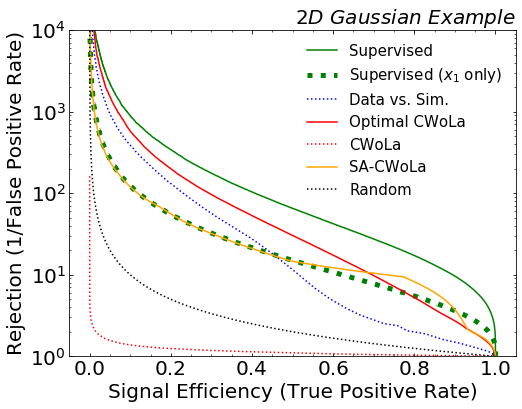

In [40]:
# Plot without banding

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med, label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.plot(tpr_pts, cwola_med,label="CWoLa",color="red",ls=":")
plt.plot(tpr_pts, sacwola_med,label="SA-CWoLa",color="orange")

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")

plt.savefig('plots/toy_medians.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/toy_medians.pdf', bbox_inches='tight', padinches=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


Text(1.0, 1.0, '$2D$ $Gaussian$ $Example$')

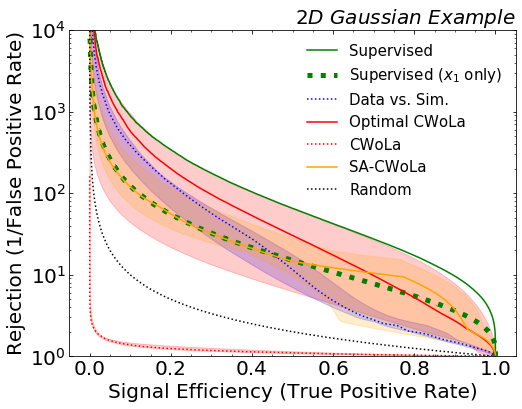

In [38]:
# Plot with banding

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med,label="Data vs. Sim.",color="blue",ls=":")
plt.fill_between(tpr_pts, dvsim_max, dvsim_min, color='blue', alpha=0.2)

plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.fill_between(tpr_pts, ocwola_max, ocwola_min, color='red', alpha=0.2)

plt.plot(tpr_pts, cwola_med,label="CWoLa",color="red",ls=":")
plt.fill_between(tpr_pts, cwola_max, cwola_min, color='red', alpha=0.2)

plt.plot(tpr_pts, sacwola_med,label="SA-CWoLa",color="orange")
plt.fill_between(tpr_pts, sacwola_max, sacwola_min, color='orange', alpha=0.2)

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


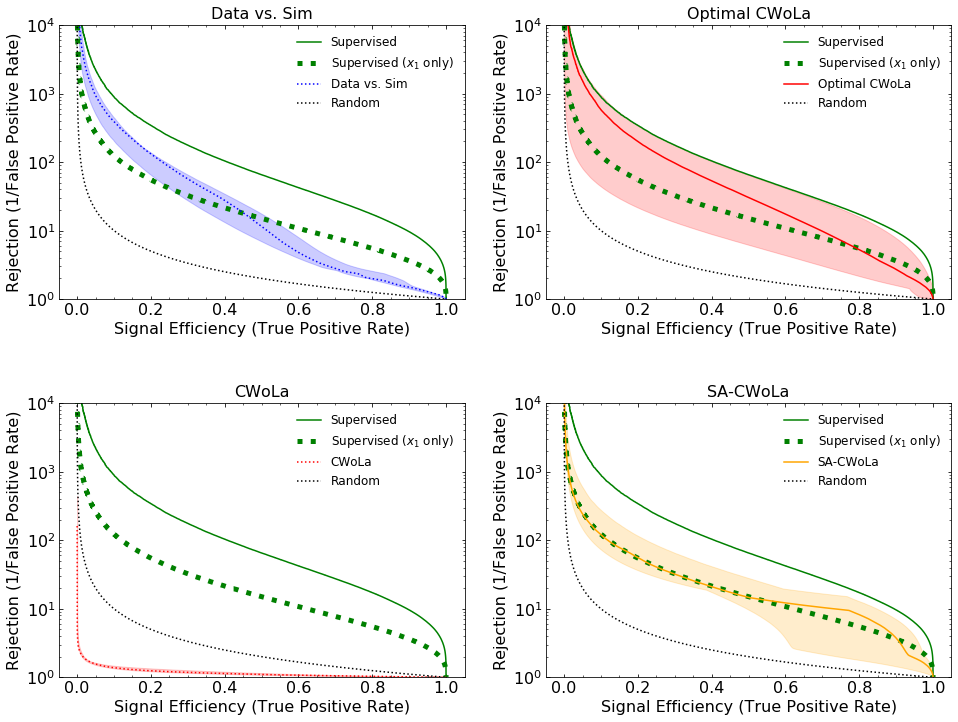

In [41]:
# Plot individual bands

bands = {'dvsim': (dvsim_max, dvsim_med, dvsim_min, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
         'ocwola': (ocwola_max, ocwola_med, ocwola_min, {'label':'Optimal CWoLa', 'color':'red'}),
         'cwola': (cwola_max, cwola_med, cwola_min, {'label':'CWoLa', 'color':'red', 'ls':':'}),
         'sacwola': (sacwola_max, sacwola_med, sacwola_min, {'label':'SA-CWoLa', 'color':'orange'})
        }

fig = plt.figure(figsize=(16, 12)) 
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.1, 1]) 

for i, key in enumerate(bands):
    row = 2 * math.floor(i / 2)
    col = i % 2
    
    ax0 = plt.subplot(gs[row, col])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.yscale("log")
    plt.ylim([1,1e4])
    
    line_max, line_med, line_min, opt = bands[key]

    plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
    plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

    plt.plot(tpr_pts, line_med, **opt)
    plt.fill_between(tpr_pts, line_max, line_min, color=opt['color'], alpha=0.2)

    plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

    plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
    plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
    plt.legend(frameon=False,fontsize=12,loc="upper right")
    
    plt.title(opt['label'], fontsize=16)

# plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")
plt.savefig('plots/toy_min_max_bands.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/toy_min_max_bands.pdf', bbox_inches='tight', padinches=0)